<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.0 MB/s 
     |████████████████████████████████| 71 kB 8.0 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619368 sha256=b0a2dcd0cd2576a522ded244eb6bd98f48c7159734cdd93f2a80d0e90f2c2890
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=1c80362a9f6e5d0331da4ed8c439f96ced3b06f98cc2c79b3a3b606a4b41e0bd
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.2 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.1-py3-none-any.whl size=73656 sha

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/KaggleImageData/UfukHocaVeri', output="output", seed=1337, ratio=(.7, 0.1,0.2)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 193 files [01:09,  2.79 files/s]


In [71]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [73]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [74]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=5)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [75]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                        rotation_range=40,
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        zoom_range=0.2,
                                                        shear_range=0.2,
                                                        horizontal_flip=True,
                                                        fill_mode='nearest')# with data augmentation for train set
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [76]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch=32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('DR.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [53]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [54]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 154ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: val_accuracy did not improve from 0.43750
Epoch 6: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 53.0776 - accuracy: 0.4375

LOSS:	53.077632904052734 	 ACCURACY:	0.4375
[53.077632904052734, 0.4375]



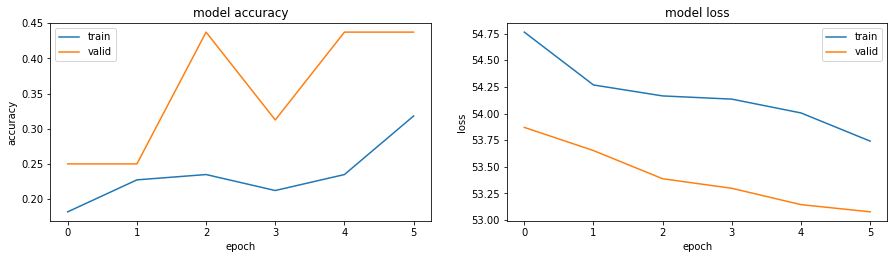


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-01 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 151ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12500 to 0.18750, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.18750 to 0.37500, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.37500 to 0.43750, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.43750

Epoch 7: val_accuracy did not improve from 0.43750
Epoch 7: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 14.3650 - accuracy: 0.4375

LOSS:	14.365032196044922 	 ACCURACY:	0.4375
[14.365032196044922, 0.4375]



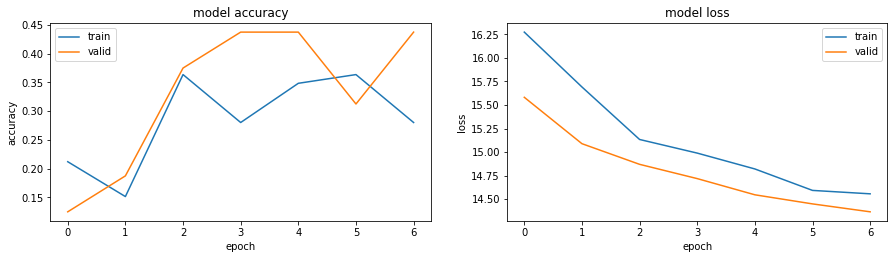


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 183ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12500 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy did not improve from 0.43750
Epoch 5: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 25.3970 - accuracy: 0.4375

LOSS:	25.397003173828125 	 ACCURACY:	0.4375
[25.397003173828125, 0.4375]



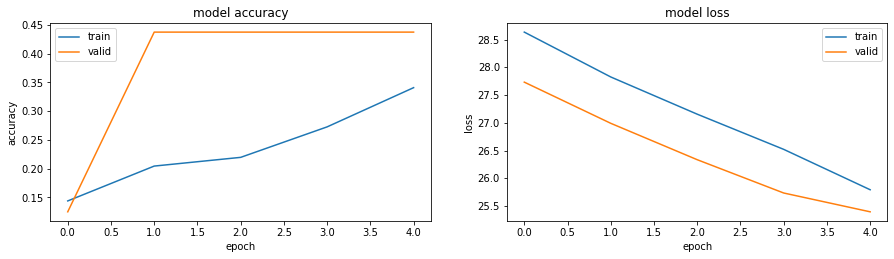


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 193ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12500 to 0.25000, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: val_accuracy did not improve from 0.43750
Epoch 6: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 103.1362 - accuracy: 0.4375

LOSS:	103.13621520996094 	 ACCURACY:	0.4375
[103.13621520996094, 0.4375]



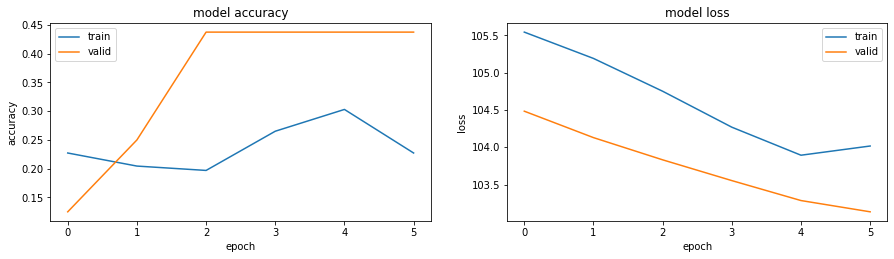


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 147ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.18750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18750

Epoch 4: val_accuracy did not improve from 0.18750
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 7.0223 - accuracy: 0.1875

LOSS:	7.02226448059082 	 ACCURACY:	0.1875
[7.02226448059082, 0.1875]



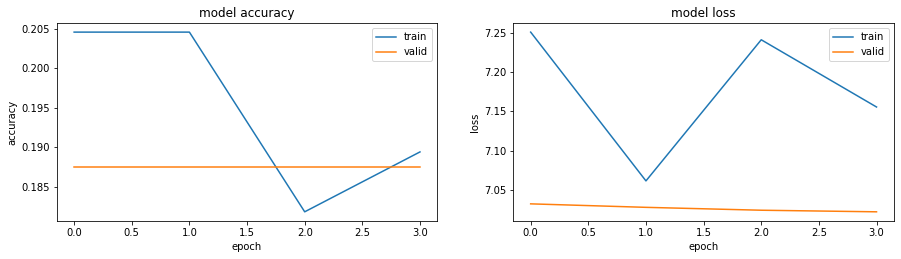




Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 145ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18750 to 0.25000, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.25000 to 0.31250, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.31250 to 0.37500, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.37500

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.37500

Epoch 7: val_accuracy did not improve from 0.37500
Epoch 7: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 2.5603 - accuracy: 0.3750

LOSS:	2.560314655303955 	 ACCURACY:	0.375
[2.560314655303955, 0.375]



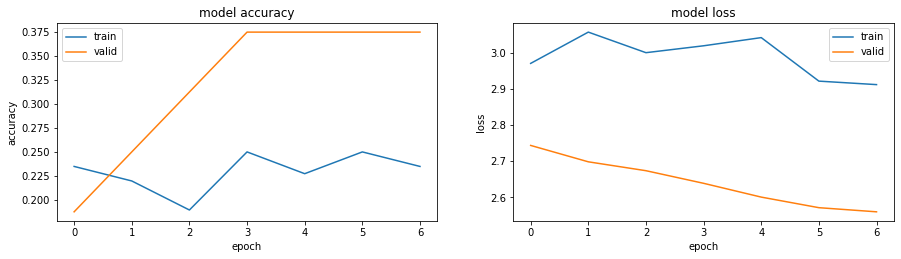


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 151ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 3.5549 - accuracy: 0.2500

LOSS:	3.554877758026123 	 ACCURACY:	0.25
[3.554877758026123, 0.25]



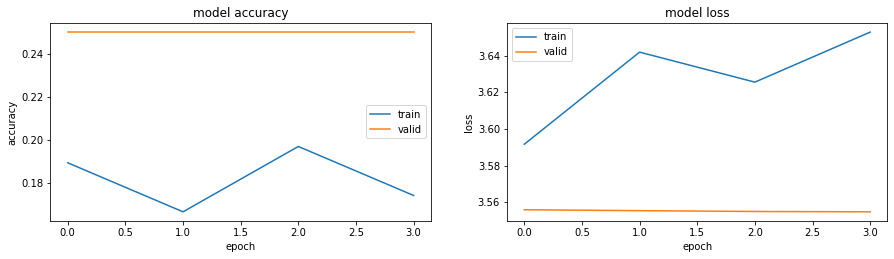


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 57ms/step - loss: 28.5241 - accuracy: 0.1250

LOSS:	28.524126052856445 	 ACCURACY:	0.125
[28.524126052856445, 0.125]



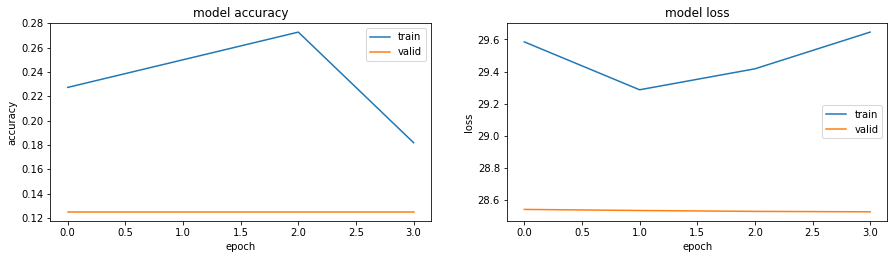


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 157ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 6.3262 - accuracy: 0.4375

LOSS:	6.326247692108154 	 ACCURACY:	0.4375
[6.326247692108154, 0.4375]



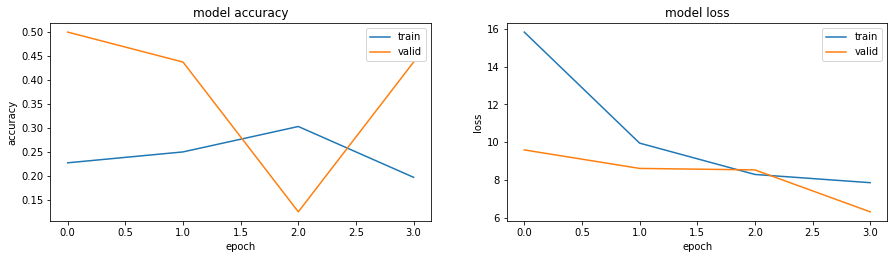


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 2.7786 - accuracy: 0.2500

LOSS:	2.778604507446289 	 ACCURACY:	0.25
[2.778604507446289, 0.25]



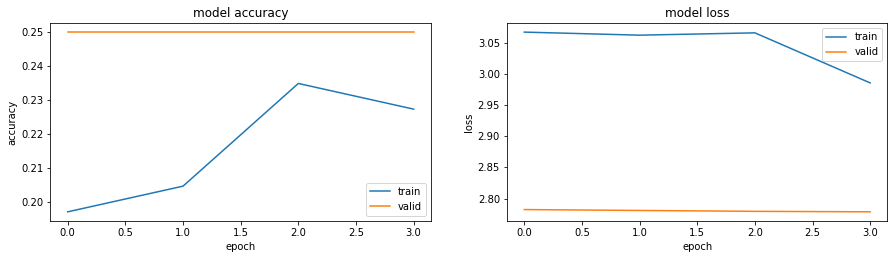


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 152ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 105.1266 - accuracy: 0.1250

LOSS:	105.12661743164062 	 ACCURACY:	0.125
[105.12661743164062, 0.125]



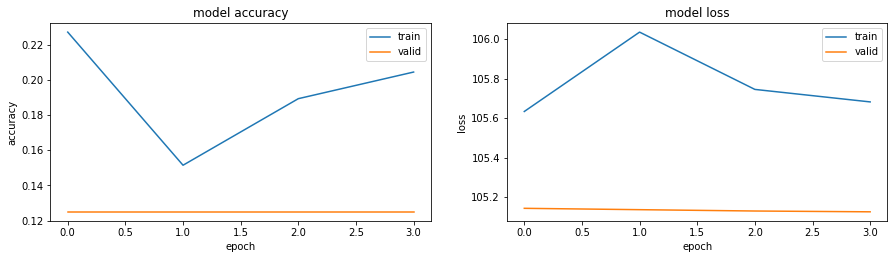


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.31250, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.31250 to 0.37500, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.37500

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.37500

Epoch 5: val_accuracy did not improve from 0.37500
Epoch 5: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 15.1789 - accuracy: 0.3750

LOSS:	15.178939819335938 	 ACCURACY:	0.375
[15.178939819335938, 0.375]



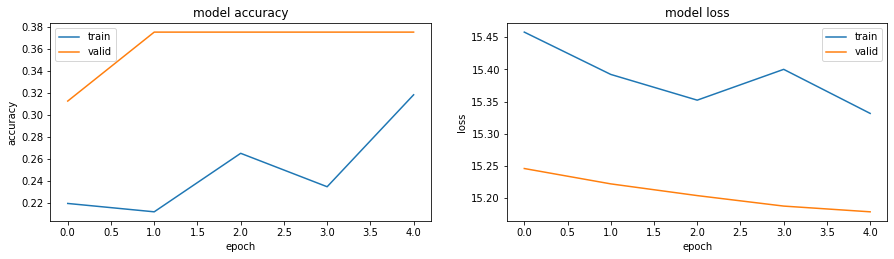


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 1.0e+00 5.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 15.1627 - accuracy: 0.5000

LOSS:	15.162652015686035 	 ACCURACY:	0.5
[15.162652015686035, 0.5]



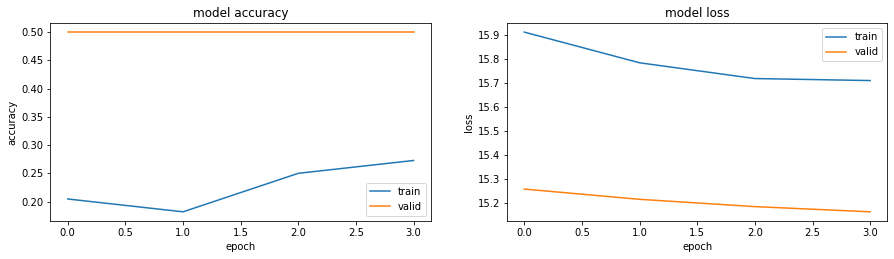


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 7.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 185ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 3.0999 - accuracy: 0.1250

LOSS:	3.0998547077178955 	 ACCURACY:	0.125
[3.0998547077178955, 0.125]



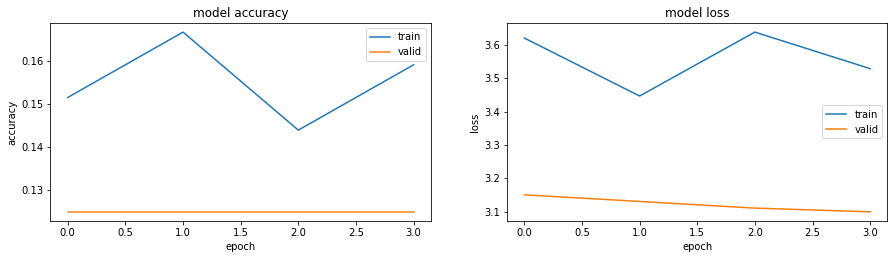


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 180ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 11.4028 - accuracy: 0.4375

LOSS:	11.40278434753418 	 ACCURACY:	0.4375
[11.40278434753418, 0.4375]



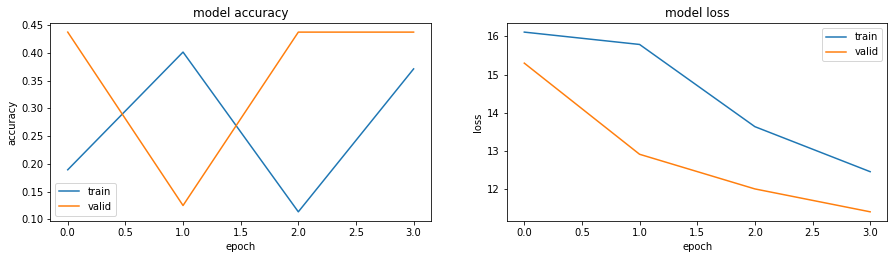


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 174ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 2.8787 - accuracy: 0.4375

LOSS:	2.878708600997925 	 ACCURACY:	0.4375
[2.878708600997925, 0.4375]



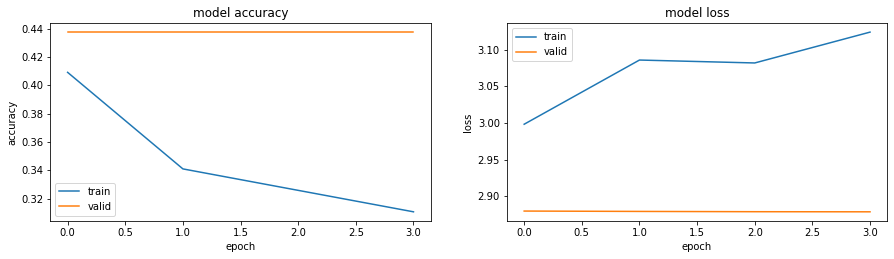


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 2.0e+00 5.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 155ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 1.9243 - accuracy: 0.1250

LOSS:	1.9243049621582031 	 ACCURACY:	0.125
[1.9243049621582031, 0.125]



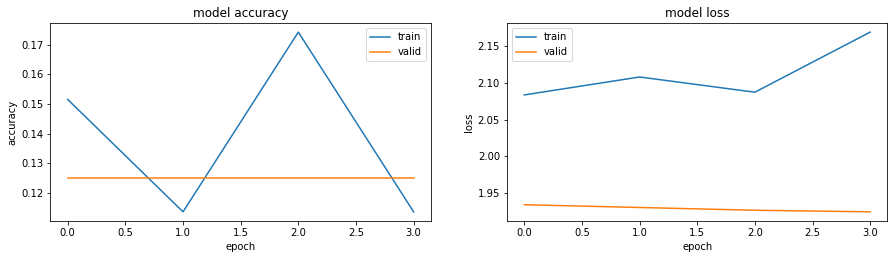


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: val_accuracy improved from 0.12500 to 0.25000, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.43750

Epoch 7: val_accuracy did not improve from 0.43750
Epoch 7: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 1.5557 - accuracy: 0.4375

LOSS:	1.5557302236557007 	 ACCURACY:	0.4375
[1.5557302236557007, 0.4375]



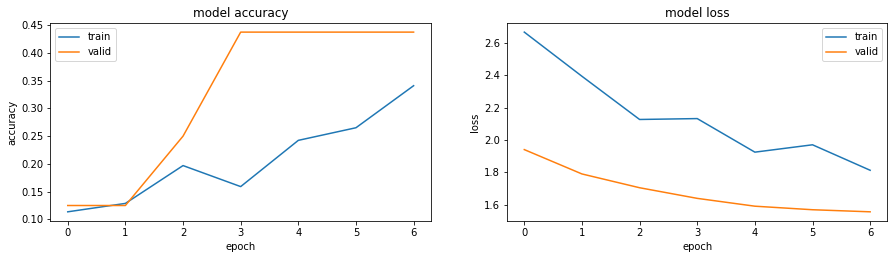


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 159ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 2.7741 - accuracy: 0.4375

LOSS:	2.7741048336029053 	 ACCURACY:	0.4375
[2.7741048336029053, 0.4375]



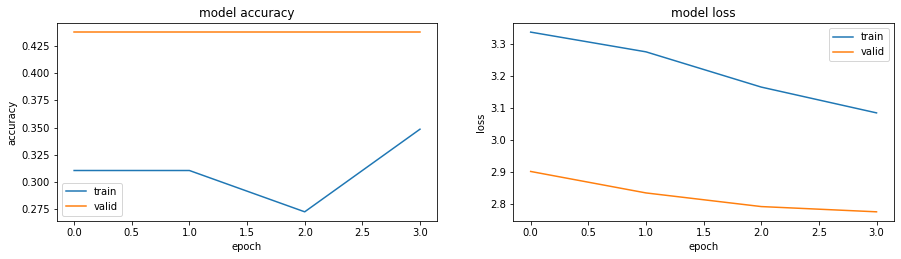


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 188ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 2.9448 - accuracy: 0.2500

LOSS:	2.944798469543457 	 ACCURACY:	0.25
[2.944798469543457, 0.25]



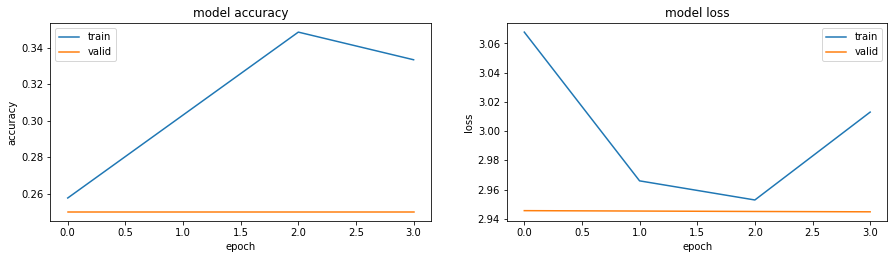


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 15.9793 - accuracy: 0.0625

LOSS:	15.979308128356934 	 ACCURACY:	0.0625
[15.979308128356934, 0.0625]



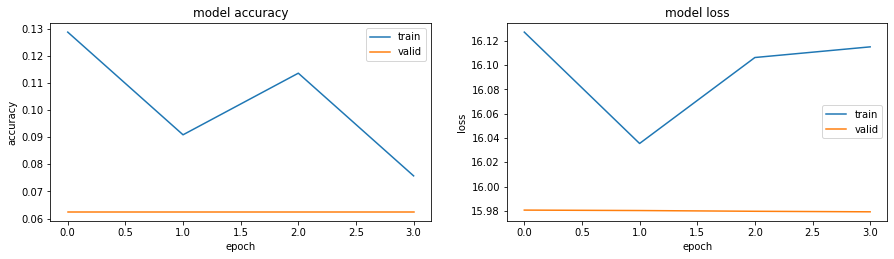


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 2.0e+00 3.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 178ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 15.4758 - accuracy: 0.4375

LOSS:	15.475797653198242 	 ACCURACY:	0.4375
[15.475797653198242, 0.4375]



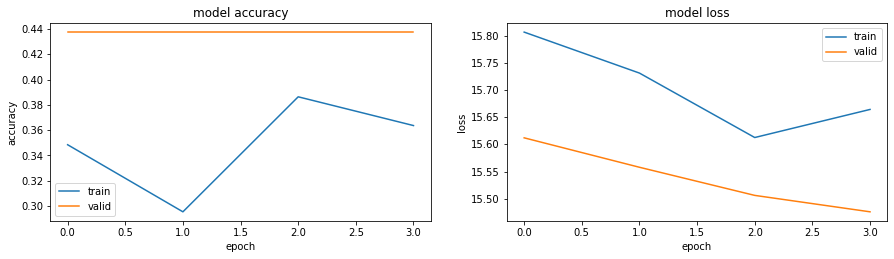


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 178ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: val_accuracy improved from 0.25000 to 0.62500, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62500

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62500

Epoch 6: val_accuracy did not improve from 0.62500
Epoch 6: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 2.8013 - accuracy: 0.5000

LOSS:	2.8012804985046387 	 ACCURACY:	0.5
[2.8012804985046387, 0.5]



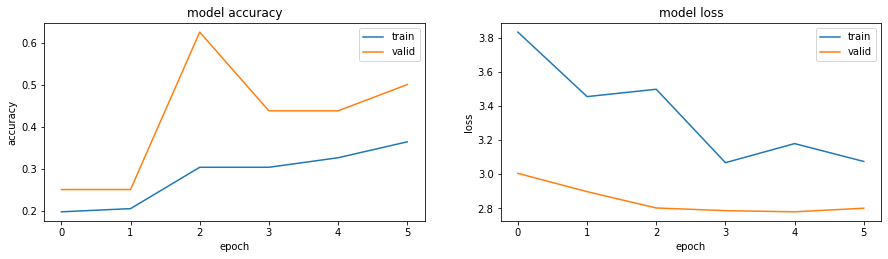


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 1.0e+00 7.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 1.5532 - accuracy: 0.4375

LOSS:	1.5531704425811768 	 ACCURACY:	0.4375
[1.5531704425811768, 0.4375]



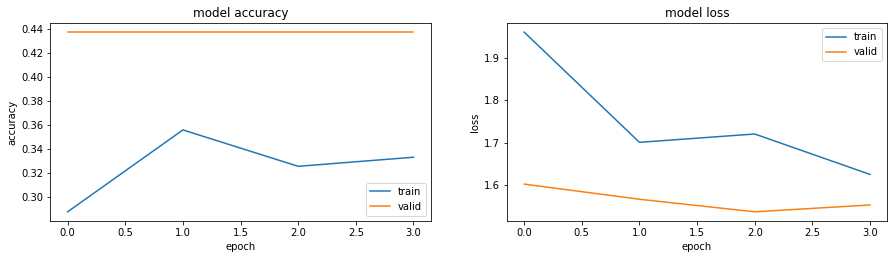


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 1.0e+00 7.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 15.2947 - accuracy: 0.4375

LOSS:	15.294706344604492 	 ACCURACY:	0.4375
[15.294706344604492, 0.4375]



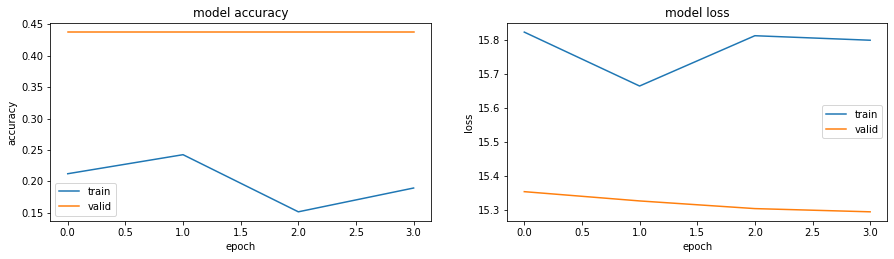


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 2.2646 - accuracy: 0.0625

LOSS:	2.2645955085754395 	 ACCURACY:	0.0625
[2.2645955085754395, 0.0625]



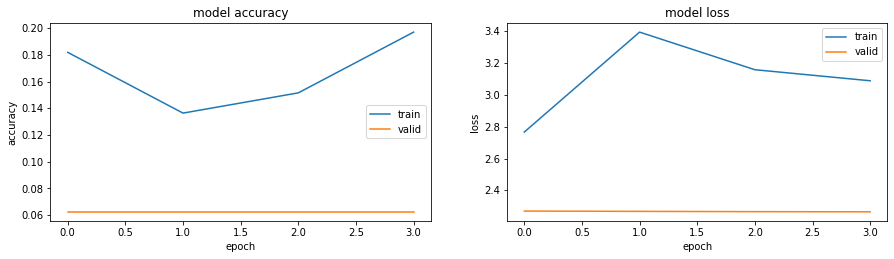


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 16.6604 - accuracy: 0.1250

LOSS:	16.660369873046875 	 ACCURACY:	0.125
[16.660369873046875, 0.125]



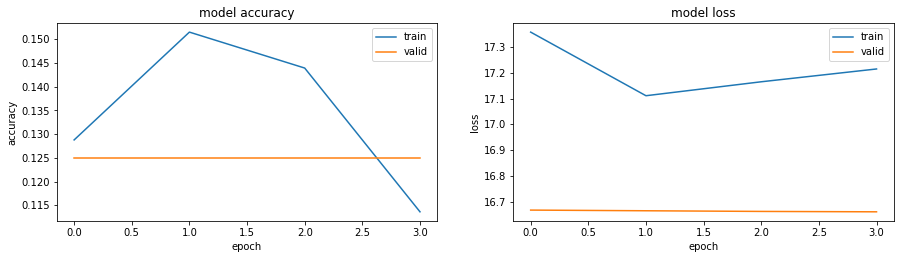


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 3.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: val_accuracy improved from 0.43750 to 0.62500, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62500

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.62500

Epoch 6: val_accuracy did not improve from 0.62500
Epoch 6: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 13.4330 - accuracy: 0.4375

LOSS:	13.432962417602539 	 ACCURACY:	0.4375
[13.432962417602539, 0.4375]



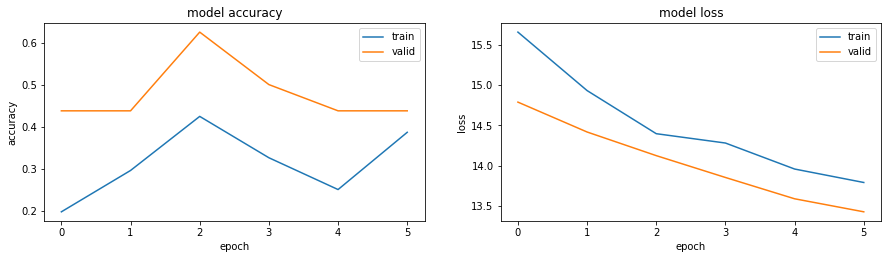


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 1s 741ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 3.1624 - accuracy: 0.1250

LOSS:	3.162444829940796 	 ACCURACY:	0.125
[3.162444829940796, 0.125]



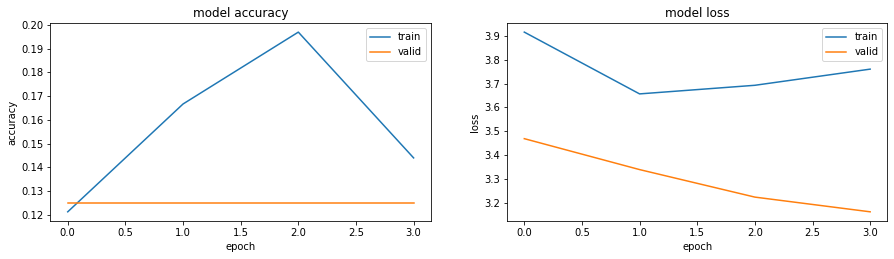


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-01 1.0e+00 3.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 185ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.00000 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy did not improve from 0.43750
Epoch 5: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 14.0122 - accuracy: 0.4375

LOSS:	14.012240409851074 	 ACCURACY:	0.4375
[14.012240409851074, 0.4375]



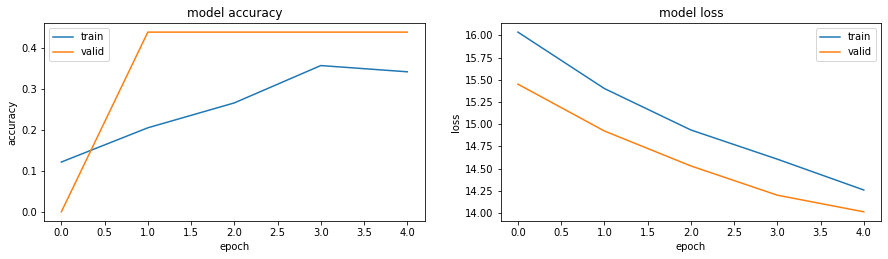


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18750 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy did not improve from 0.43750
Epoch 5: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 1.6222 - accuracy: 0.4375

LOSS:	1.6221849918365479 	 ACCURACY:	0.4375
[1.6221849918365479, 0.4375]



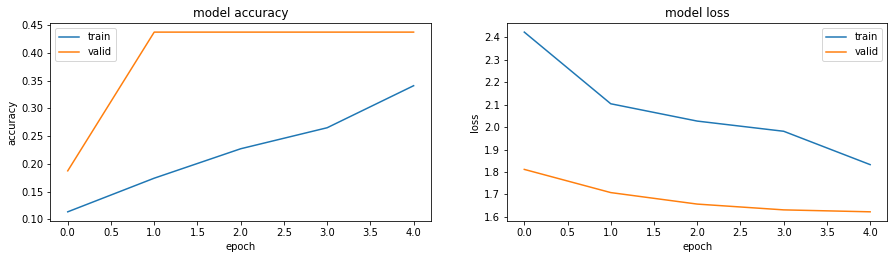


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 3.0104 - accuracy: 0.4375

LOSS:	3.010411024093628 	 ACCURACY:	0.4375
[3.010411024093628, 0.4375]



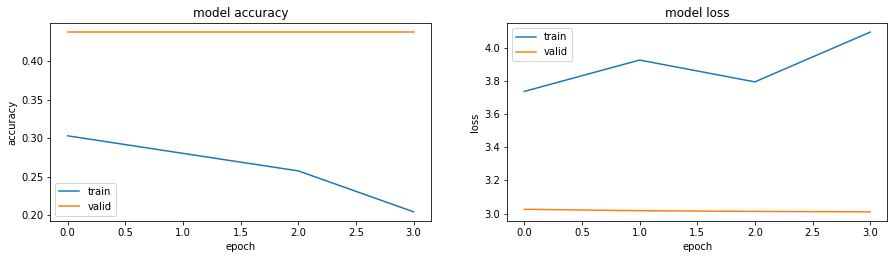


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 2.0e+00 5.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 182ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 3.5526 - accuracy: 0.1250

LOSS:	3.552595853805542 	 ACCURACY:	0.125
[3.552595853805542, 0.125]



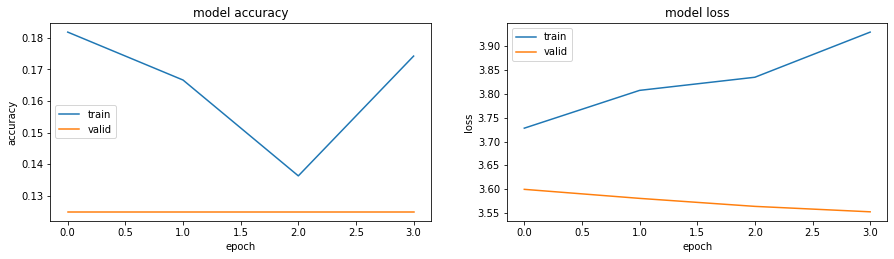


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 1.0e+00 7.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 160ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 5.9868 - accuracy: 0.4375

LOSS:	5.986817359924316 	 ACCURACY:	0.4375
[5.986817359924316, 0.4375]



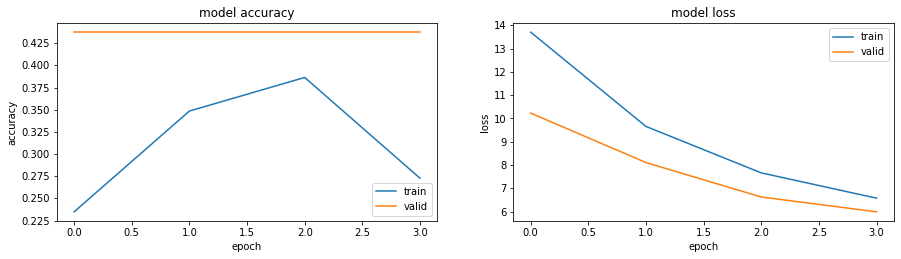


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 2.9190 - accuracy: 0.1250

LOSS:	2.9189720153808594 	 ACCURACY:	0.125
[2.9189720153808594, 0.125]



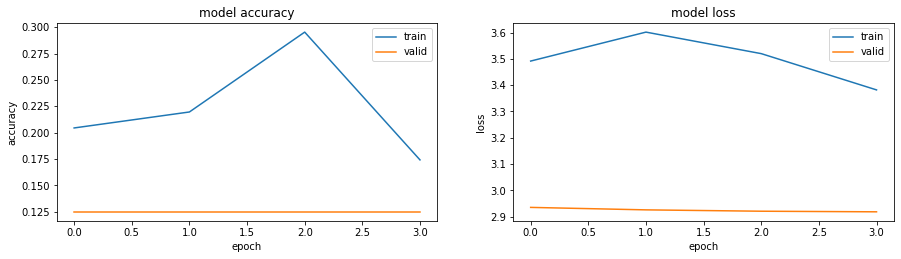


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 187ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 3.6239 - accuracy: 0.0625

LOSS:	3.623919725418091 	 ACCURACY:	0.0625
[3.623919725418091, 0.0625]



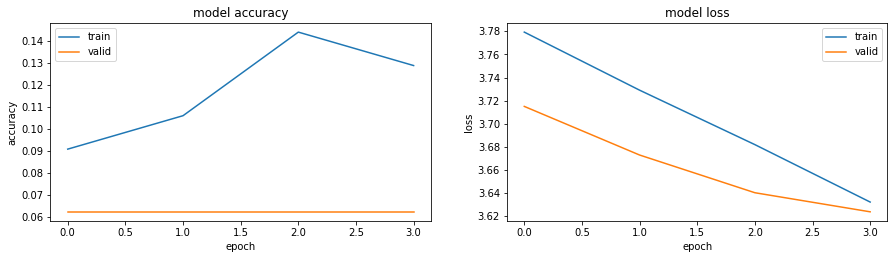


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 2.7017 - accuracy: 0.2500

LOSS:	2.701687812805176 	 ACCURACY:	0.25
[2.701687812805176, 0.25]



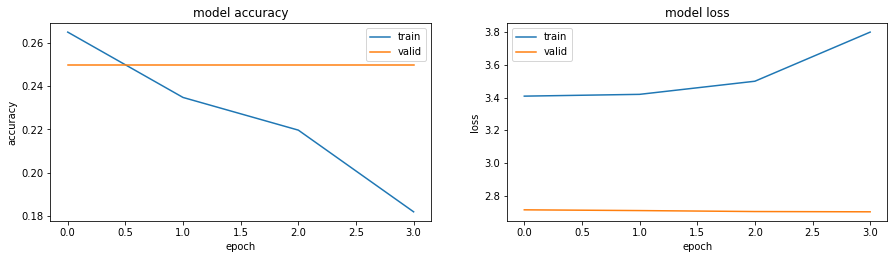


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 160ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.43750 to 0.50000, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.50000

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.50000

Epoch 6: val_accuracy did not improve from 0.50000
Epoch 6: early stopping
1/1 [==============================] - 0s 33ms/step - loss: 1.5651 - accuracy: 0.4375

LOSS:	1.5651345252990723 	 ACCURACY:	0.4375
[1.5651345252990723, 0.4375]



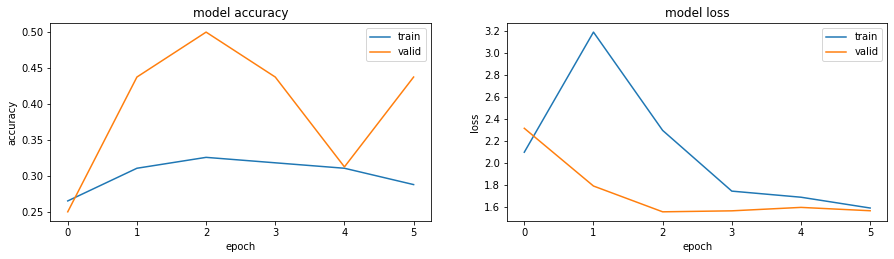


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 3.0e+00 7.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 1.5498 - accuracy: 0.4375

LOSS:	1.5498415231704712 	 ACCURACY:	0.4375
[1.5498415231704712, 0.4375]



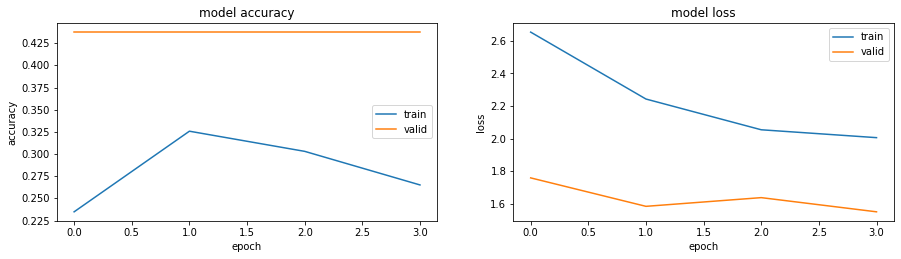


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 183ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 2.7932 - accuracy: 0.4375

LOSS:	2.7932143211364746 	 ACCURACY:	0.4375
[2.7932143211364746, 0.4375]



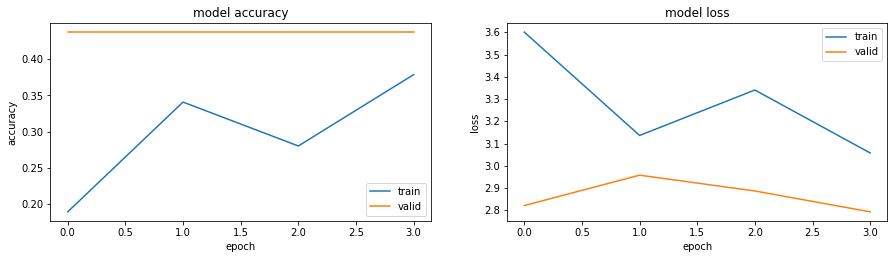


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 182ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 3.2505 - accuracy: 0.0625

LOSS:	3.2505452632904053 	 ACCURACY:	0.0625
[3.2505452632904053, 0.0625]



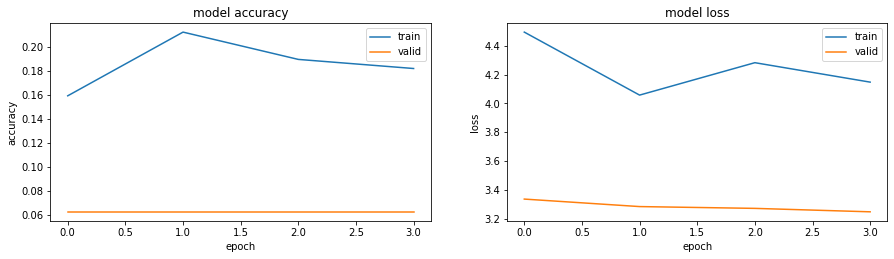


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 15.2628 - accuracy: 0.4375

LOSS:	15.262796401977539 	 ACCURACY:	0.4375
[15.262796401977539, 0.4375]



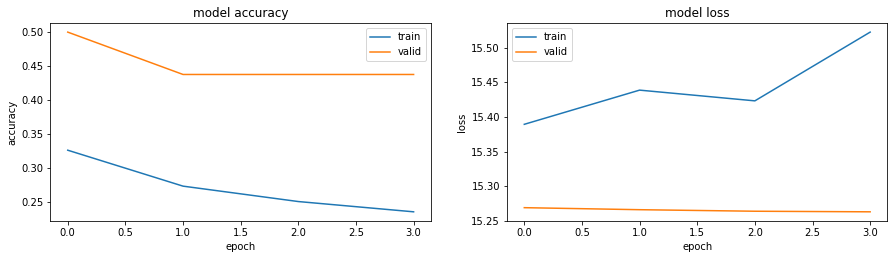


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 2.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 178ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 2.6442 - accuracy: 0.4375

LOSS:	2.6442184448242188 	 ACCURACY:	0.4375
[2.6442184448242188, 0.4375]



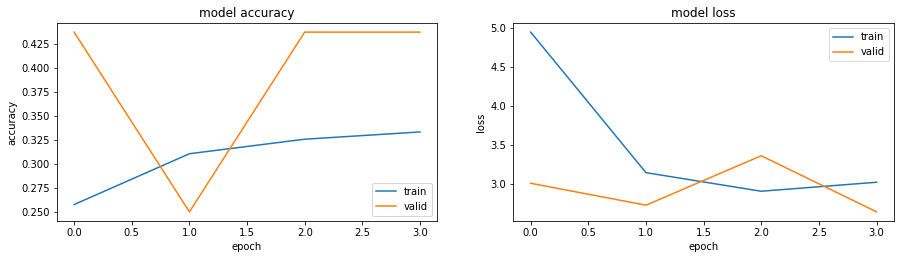


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 178ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12500 to 0.50000, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.50000

Epoch 5: val_accuracy did not improve from 0.50000
Epoch 5: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 2.8564 - accuracy: 0.4375

LOSS:	2.8564181327819824 	 ACCURACY:	0.4375
[2.8564181327819824, 0.4375]



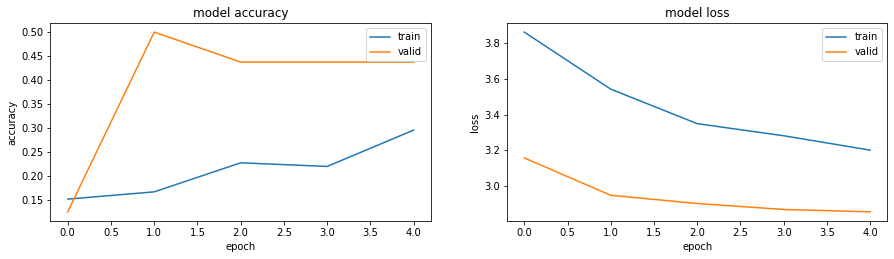


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 16.3226 - accuracy: 0.1250

LOSS:	16.322622299194336 	 ACCURACY:	0.125
[16.322622299194336, 0.125]



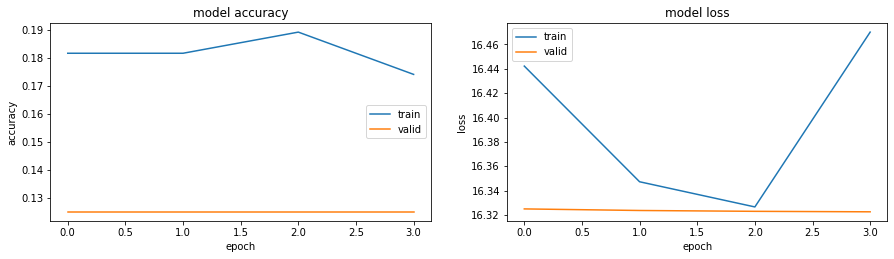


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 3.2716 - accuracy: 0.0000e+00

LOSS:	3.2716028690338135 	 ACCURACY:	0.0
[3.2716028690338135, 0.0]



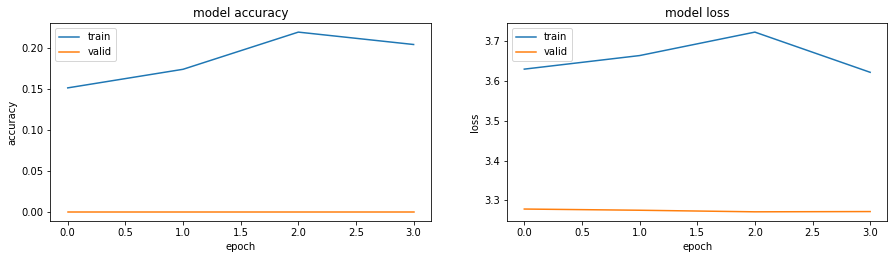


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12500 to 0.31250, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.31250

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.31250

Epoch 5: val_accuracy improved from 0.31250 to 0.37500, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.37500 to 0.43750, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.43750

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 8: val_accuracy did not improve from 0.43750

Epoch 9: val_accuracy did not improve from 0.43750
Epoch 9: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 2.7754 - accuracy

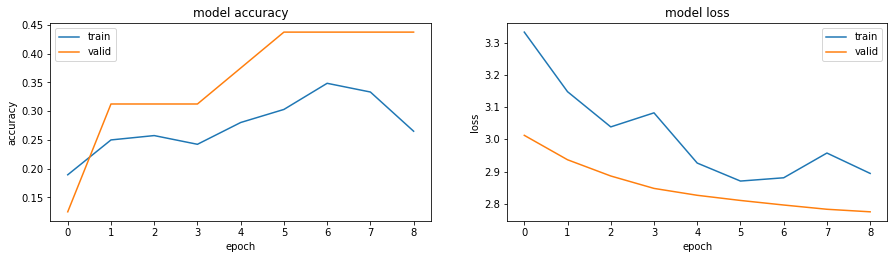


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 182ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 2.8622 - accuracy: 0.4375

LOSS:	2.862177610397339 	 ACCURACY:	0.4375
[2.862177610397339, 0.4375]



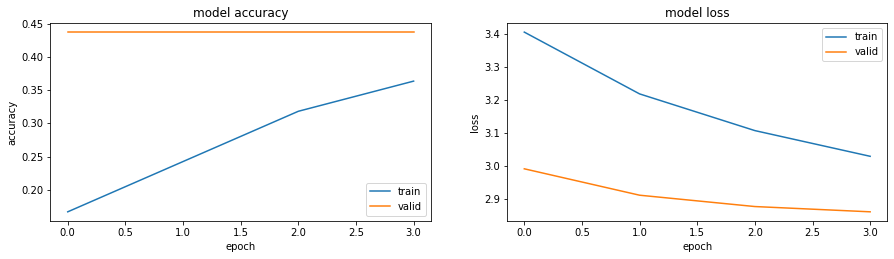


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-01 3.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 174ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 15.3031 - accuracy: 0.4375

LOSS:	15.303146362304688 	 ACCURACY:	0.4375
[15.303146362304688, 0.4375]



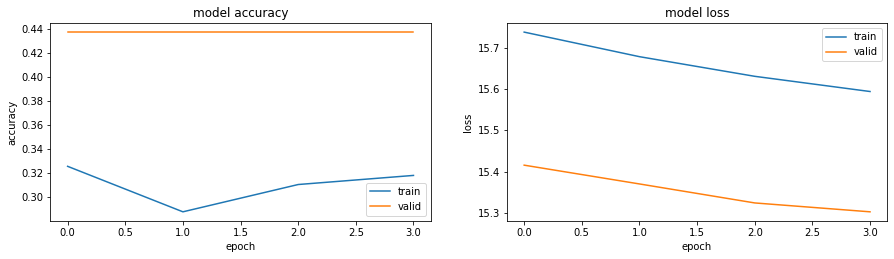


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 15.7422 - accuracy: 0.1250

LOSS:	15.742218017578125 	 ACCURACY:	0.125
[15.742218017578125, 0.125]



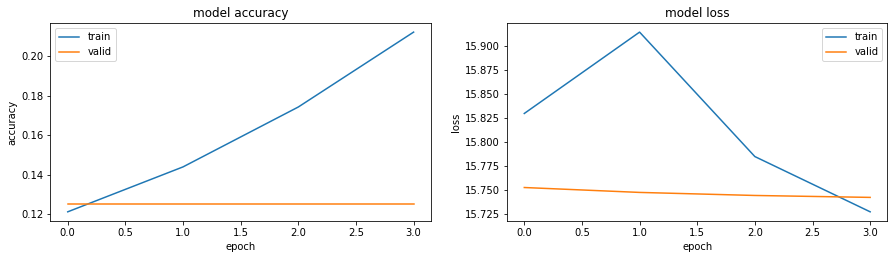


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 1.0e+00 5.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy did not improve from 0.43750
Epoch 5: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 1.5463 - accuracy: 0.4375

LOSS:	1.5462509393692017 	 ACCURACY:	0.4375
[1.5462509393692017, 0.4375]



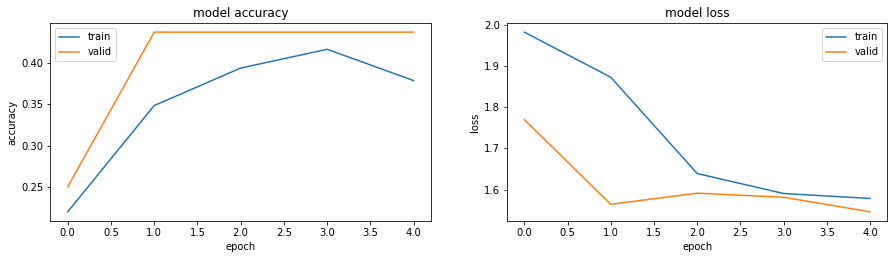


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 189ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000
Epoch 4: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 2.8902 - accuracy: 0.2500

LOSS:	2.8901731967926025 	 ACCURACY:	0.25
[2.8901731967926025, 0.25]



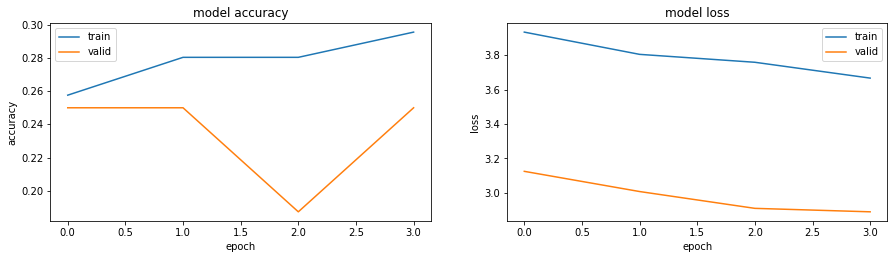


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 195ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 3.2020 - accuracy: 0.0625

LOSS:	3.2020442485809326 	 ACCURACY:	0.0625
[3.2020442485809326, 0.0625]



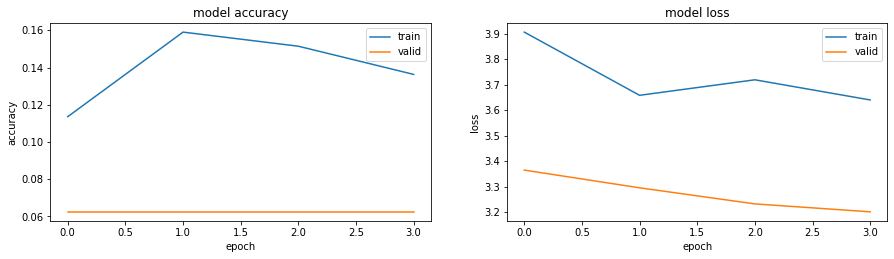


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 2.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.43750 to 0.50000, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.50000

Epoch 5: val_accuracy did not improve from 0.50000
Epoch 5: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 2.6090 - accuracy: 0.4375

LOSS:	2.6089859008789062 	 ACCURACY:	0.4375
[2.6089859008789062, 0.4375]



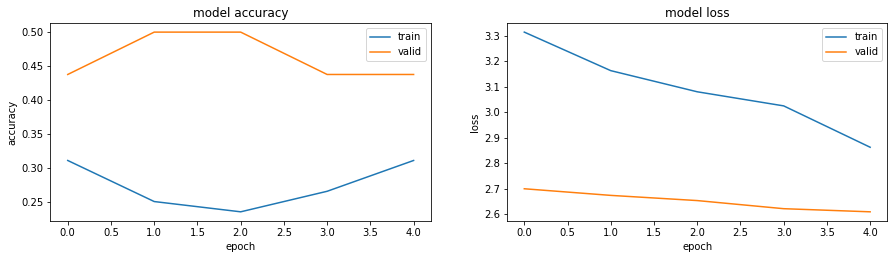


Hyperparameters: [[6.4e+01 1.0e-05 1.0e-02 1.0e+00 3.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 2.8875 - accuracy: 0.4375

LOSS:	2.887515068054199 	 ACCURACY:	0.4375
[2.887515068054199, 0.4375]



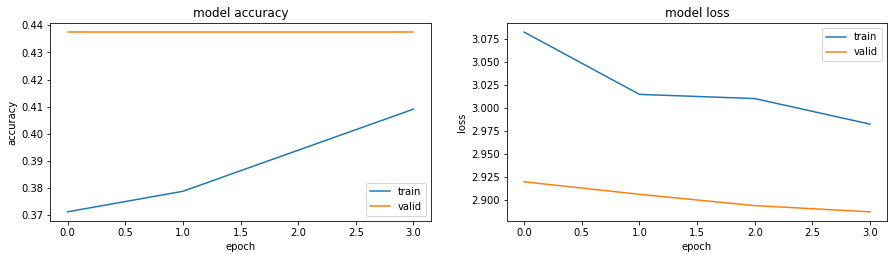


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 176ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.06250 to 0.12500, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy improved from 0.12500 to 0.18750, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18750 to 0.37500, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.37500 to 0.43750, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.43750 to 0.50000, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.50000

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.50000

Epoch 10: val_accuracy did not improve from 0.50000
Epoch 10: early stopping
1/1 [==============================] - 0s 33ms

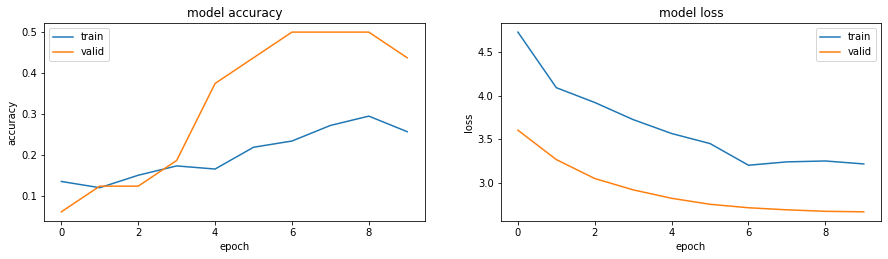


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-03 3.0e+00 3.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 1.5415 - accuracy: 0.4375

LOSS:	1.5415334701538086 	 ACCURACY:	0.4375
[1.5415334701538086, 0.4375]



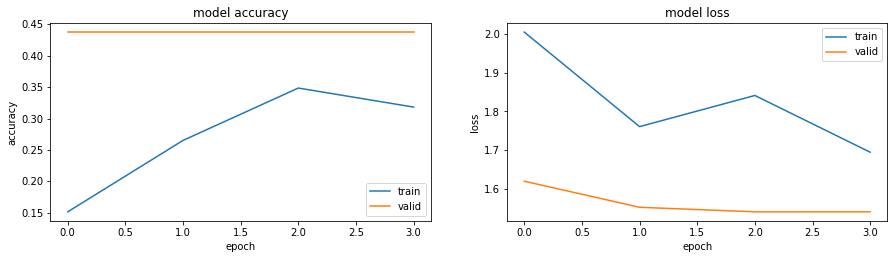


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 174ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy improved from 0.06250 to 0.18750, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18750 to 0.31250, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.31250

Epoch 7: val_accuracy improved from 0.31250 to 0.50000, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.50000

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.50000

Epoch 10: val_accuracy did not improve from 0.50000
Epoch 10: early stopping
1/1 [==================

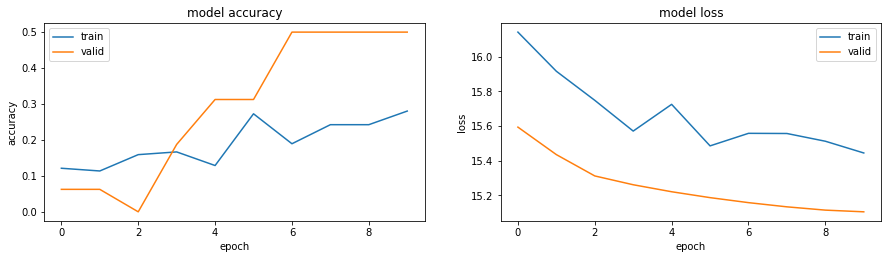


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18750 to 0.25000, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.25000

Epoch 5: val_accuracy did not improve from 0.25000
Epoch 5: early stopping
1/1 [==============================] - 0s 28ms/step - loss: 1.7658 - accuracy: 0.2500

LOSS:	1.765775203704834 	 ACCURACY:	0.25
[1.765775203704834, 0.25]



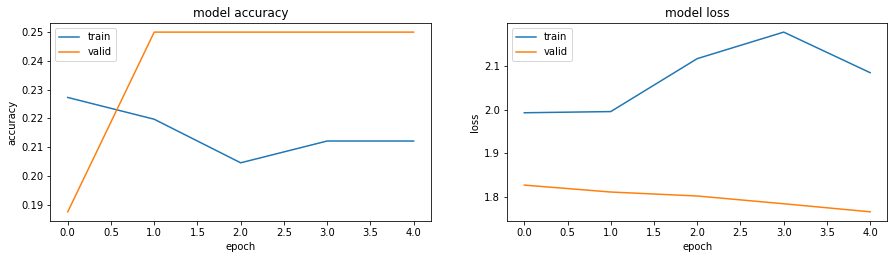


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 1.0e+00 3.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy improved from 0.12500 to 0.18750, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18750 to 0.31250, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.31250 to 0.37500, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.37500

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 8: val_accuracy did not improve from 0.37500

Epoch 9: val_accuracy did not improve from 0.37500
Epoch 9: early stopping
1/1 [==============================] - 0s 26ms/step - loss: 3.1207 - accuracy: 0.375

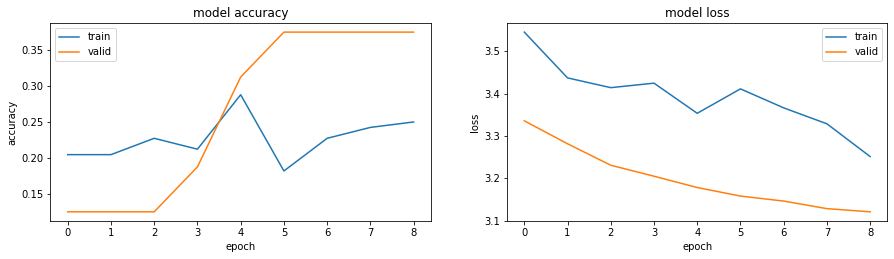


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.37500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.37500

Epoch 4: val_accuracy did not improve from 0.37500
Epoch 4: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 1.6493 - accuracy: 0.3125

LOSS:	1.6493288278579712 	 ACCURACY:	0.3125
[1.6493288278579712, 0.3125]



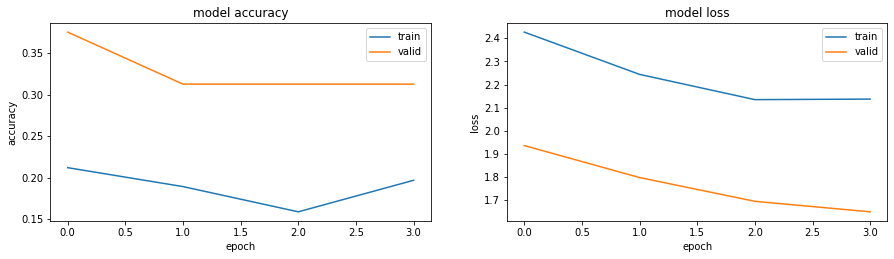


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 2.3904 - accuracy: 0.1250

LOSS:	2.3903841972351074 	 ACCURACY:	0.125
[2.3903841972351074, 0.125]



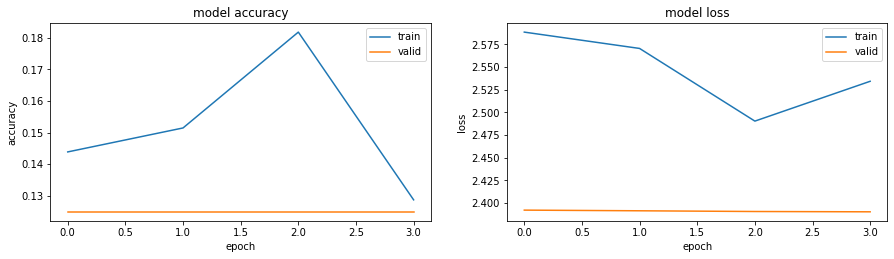


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 185ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 15.4938 - accuracy: 0.1250

LOSS:	15.493821144104004 	 ACCURACY:	0.125
[15.493821144104004, 0.125]



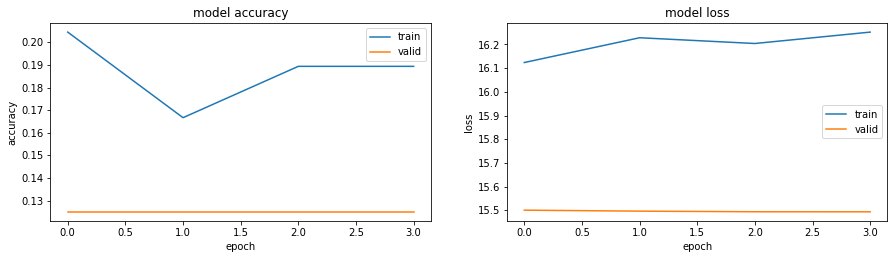


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-03 1.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 1.6724 - accuracy: 0.5000

LOSS:	1.6724175214767456 	 ACCURACY:	0.5
[1.6724175214767456, 0.5]



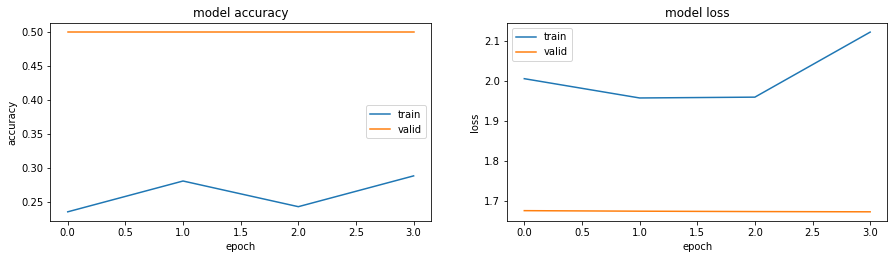


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-02 1.0e+00 5.0e-01 3.2e+01 1.0e+00]]
1/1 [==============================] - 0s 161ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000
Epoch 4: early stopping
1/1 [==============================] - 0s 21ms/step - loss: 2.0586 - accuracy: 0.4375

LOSS:	2.0586252212524414 	 ACCURACY:	0.4375
[2.0586252212524414, 0.4375]



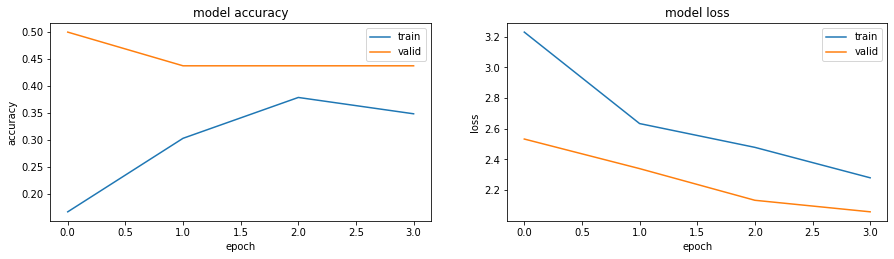


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-01 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 34ms/step - loss: 16.1507 - accuracy: 0.0625

LOSS:	16.15066909790039 	 ACCURACY:	0.0625
[16.15066909790039, 0.0625]



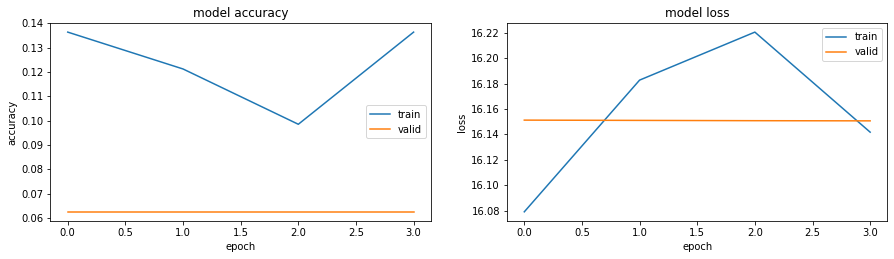


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 157ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.25000 to 0.37500, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.37500 to 0.43750, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: val_accuracy did not improve from 0.43750
Epoch 6: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 1.7162 - accuracy: 0.4375

LOSS:	1.7162182331085205 	 ACCURACY:	0.4375
[1.7162182331085205, 0.4375]



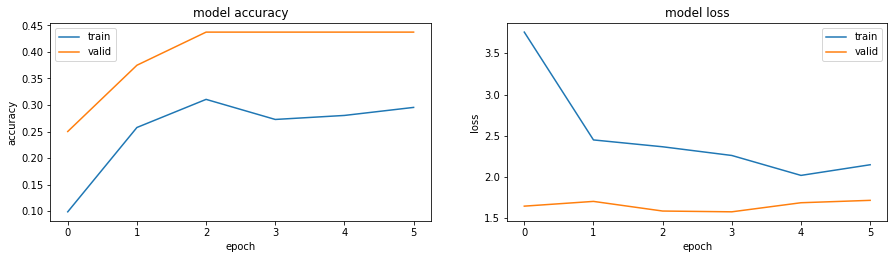


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 186ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 11.1839 - accuracy: 0.4375

LOSS:	11.183884620666504 	 ACCURACY:	0.4375
[11.183884620666504, 0.4375]



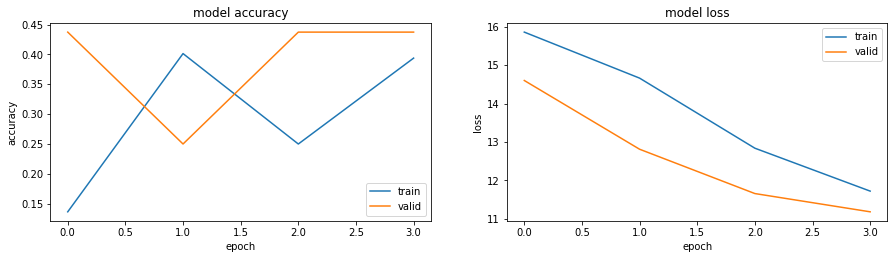


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-01 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 207ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.31250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.31250

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.31250

Epoch 4: val_accuracy did not improve from 0.31250
Epoch 4: early stopping
1/1 [==============================] - 0s 34ms/step - loss: 11.8625 - accuracy: 0.1250

LOSS:	11.862464904785156 	 ACCURACY:	0.125
[11.862464904785156, 0.125]



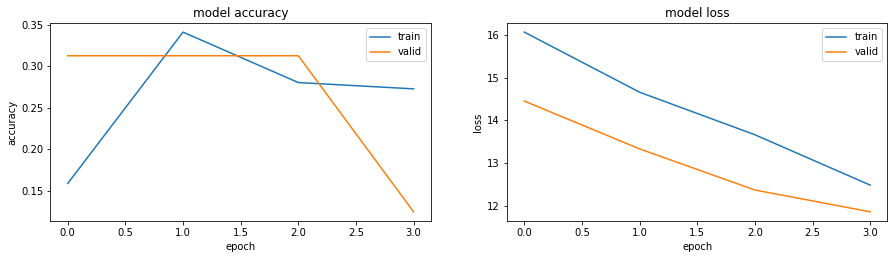


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 3.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: val_accuracy improved from 0.43750 to 0.62500, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62500

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62500

Epoch 6: val_accuracy did not improve from 0.62500
Epoch 6: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 2.6848 - accuracy: 0.4375

LOSS:	2.6847641468048096 	 ACCURACY:	0.4375
[2.6847641468048096, 0.4375]



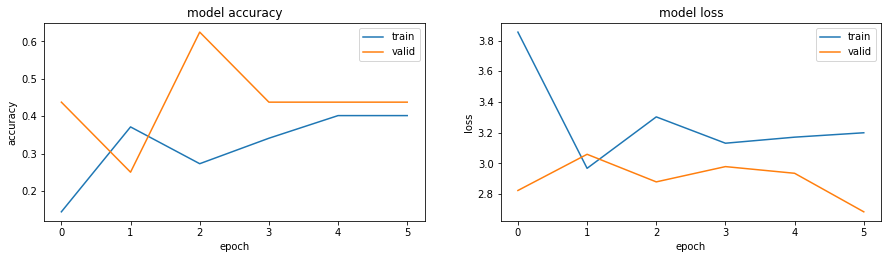


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 3.0e+00 5.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 193ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.06250 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy did not improve from 0.43750
Epoch 5: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 2.6799 - accuracy: 0.4375

LOSS:	2.679884910583496 	 ACCURACY:	0.4375
[2.679884910583496, 0.4375]



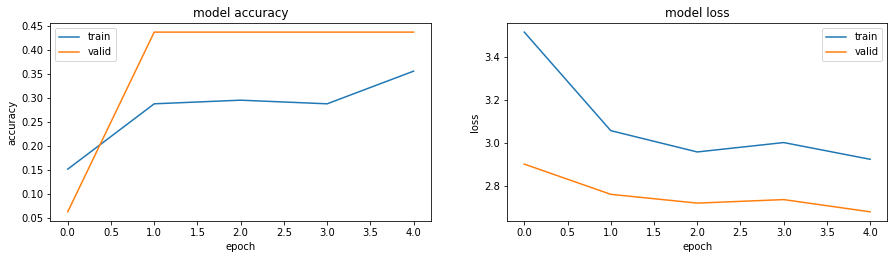


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 176ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 1.5394 - accuracy: 0.4375

LOSS:	1.5394043922424316 	 ACCURACY:	0.4375
[1.5394043922424316, 0.4375]



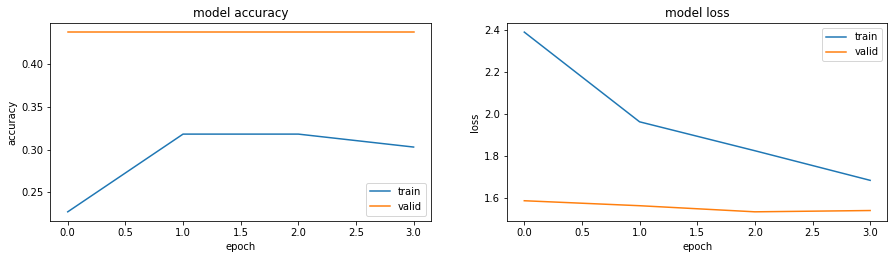


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-01 3.0e+00 7.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 163ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.00000

Epoch 4: val_accuracy did not improve from 0.00000
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 15.7204 - accuracy: 0.0000e+00

LOSS:	15.720353126525879 	 ACCURACY:	0.0
[15.720353126525879, 0.0]



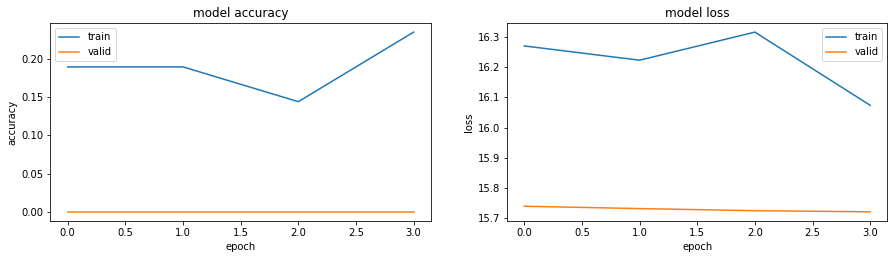


Hyperparameters: [[6.4e+01 1.0e-06 1.0e-02 2.0e+00 5.0e-01 3.2e+01 2.0e+00]]
1/1 [==============================] - 0s 165ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.18750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.18750

Epoch 4: val_accuracy did not improve from 0.18750
Epoch 4: early stopping
1/1 [==============================] - 0s 38ms/step - loss: 3.1720 - accuracy: 0.1250

LOSS:	3.172023296356201 	 ACCURACY:	0.125
[3.172023296356201, 0.125]



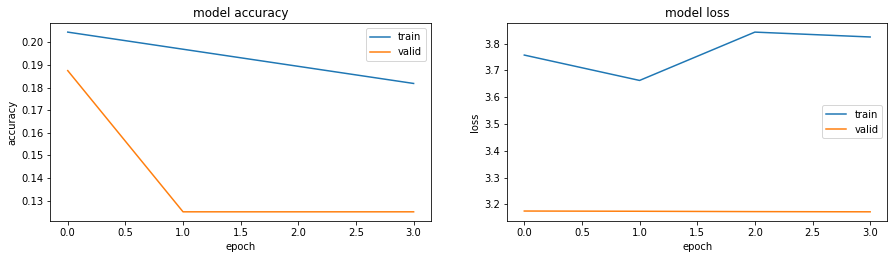


Hyperparameters: [[6.4e+01 1.0e-03 1.0e-01 1.0e+00 3.0e-01 3.2e+01 3.0e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy did not improve from 0.43750
Epoch 5: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 5.1731 - accuracy: 0.4375

LOSS:	5.173130035400391 	 ACCURACY:	0.4375
[5.173130035400391, 0.4375]



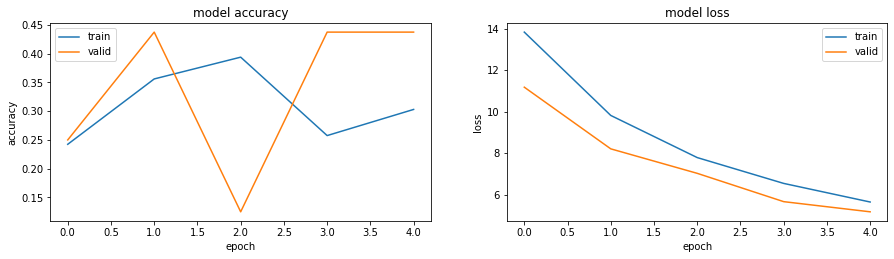


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-01 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 168ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 15.5325 - accuracy: 0.1250

LOSS:	15.532502174377441 	 ACCURACY:	0.125
[15.532502174377441, 0.125]



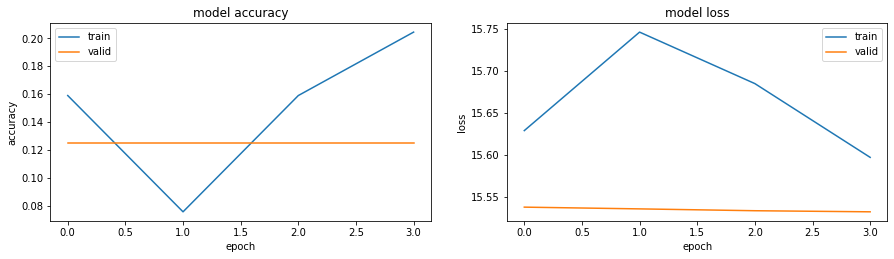


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 162ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.37500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.37500

Epoch 4: val_accuracy did not improve from 0.37500
Epoch 4: early stopping
1/1 [==============================] - 0s 36ms/step - loss: 1.6455 - accuracy: 0.3750

LOSS:	1.6454854011535645 	 ACCURACY:	0.375
[1.6454854011535645, 0.375]



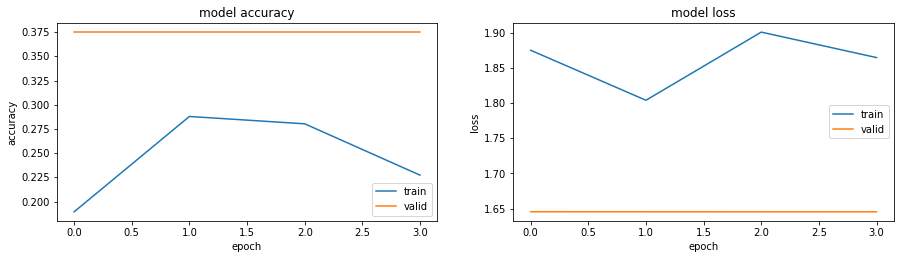


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 173ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 1.8209 - accuracy: 0.0625

LOSS:	1.8209235668182373 	 ACCURACY:	0.0625
[1.8209235668182373, 0.0625]



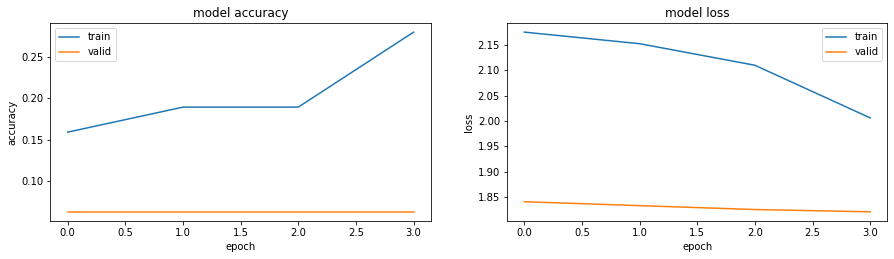


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: val_accuracy did not improve from 0.43750
Epoch 6: early stopping
1/1 [==============================] - 0s 22ms/step - loss: 2.8134 - accuracy: 0.4375

LOSS:	2.8134195804595947 	 ACCURACY:	0.4375
[2.8134195804595947, 0.4375]



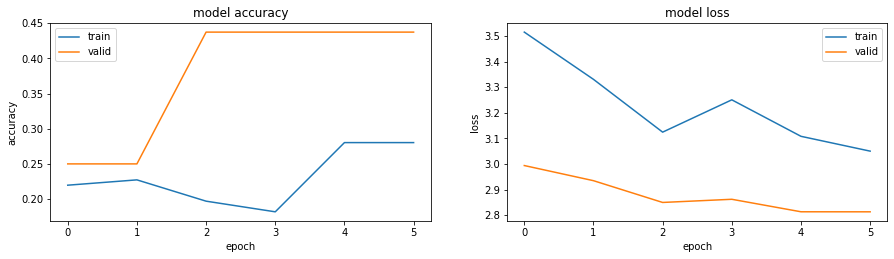


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 37ms/step - loss: 1.9655 - accuracy: 0.1250

LOSS:	1.9654626846313477 	 ACCURACY:	0.125
[1.9654626846313477, 0.125]



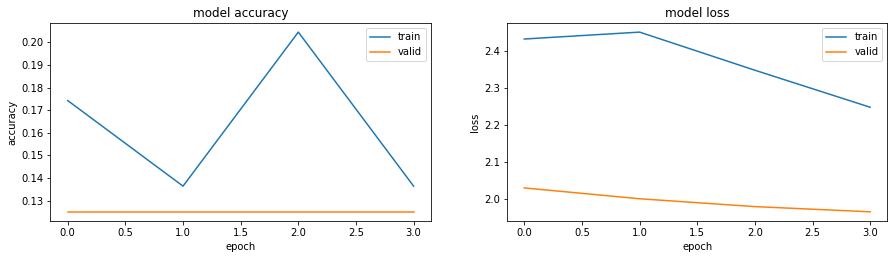


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 1.6782 - accuracy: 0.1250

LOSS:	1.6782011985778809 	 ACCURACY:	0.125
[1.6782011985778809, 0.125]



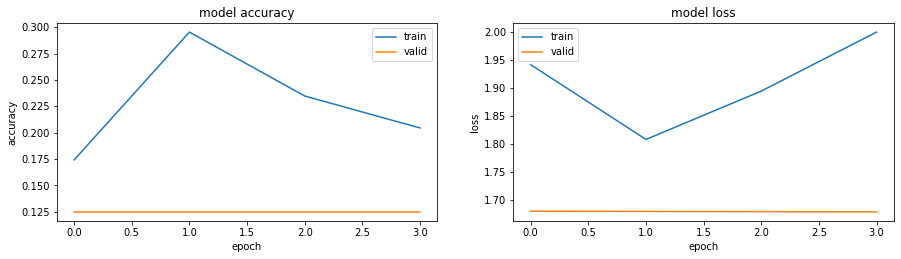


Hyperparameters: [[6.40e+01 1.00e-04 1.00e-03 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.50000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.50000

Epoch 4: val_accuracy did not improve from 0.50000
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 1.6919 - accuracy: 0.4375

LOSS:	1.6918665170669556 	 ACCURACY:	0.4375
[1.6918665170669556, 0.4375]



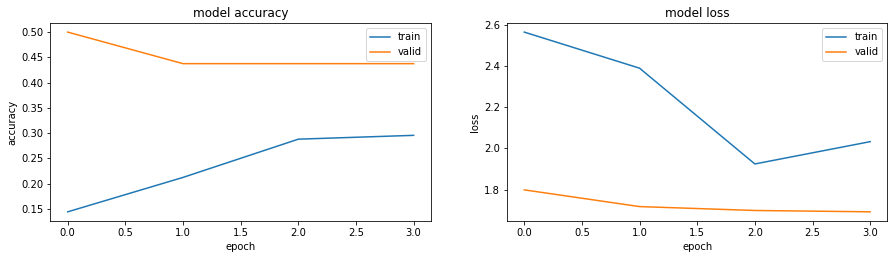


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-03 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 190ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 2.0182 - accuracy: 0.0625

LOSS:	2.0181891918182373 	 ACCURACY:	0.0625
[2.0181891918182373, 0.0625]



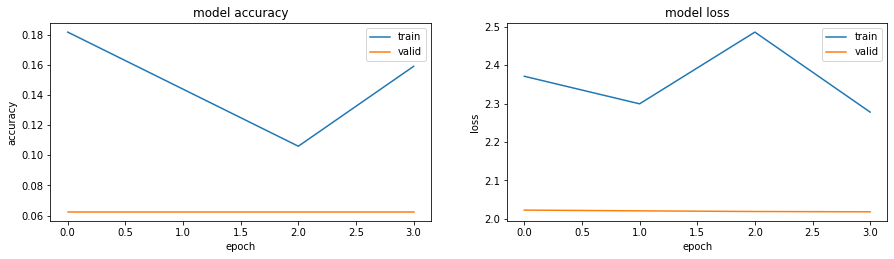


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 180ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 2.0116 - accuracy: 0.1250

LOSS:	2.011570453643799 	 ACCURACY:	0.125
[2.011570453643799, 0.125]



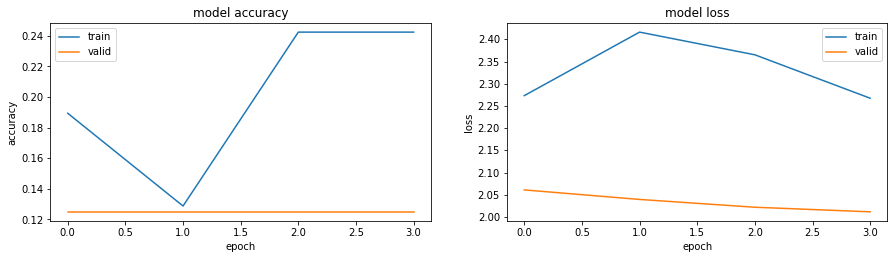


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 200ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.12500 to 0.31250, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.31250 to 0.37500, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.37500 to 0.43750, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.43750

Epoch 7: val_accuracy did not improve from 0.43750
Epoch 7: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 1.8628 - accuracy: 0.4375

LOSS:	1.8627768754959106 	 ACCURACY:	0.4375
[1.8627768754959106, 0.4375]



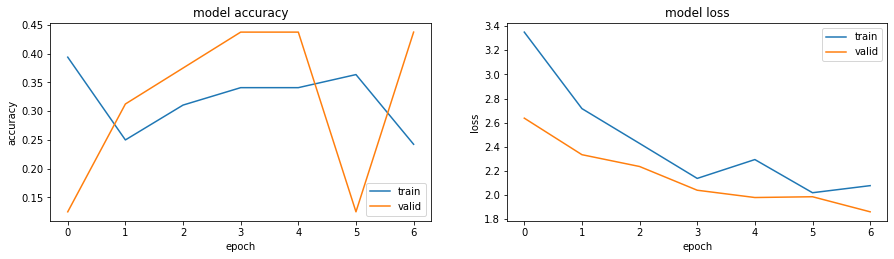


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 11.8163 - accuracy: 0.4375

LOSS:	11.816337585449219 	 ACCURACY:	0.4375
[11.816337585449219, 0.4375]



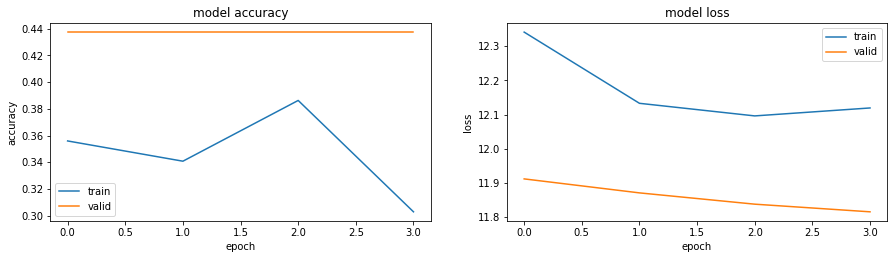


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
1/1 [==============================] - 0s 179ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.06250 to 0.18750, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.18750 to 0.43750, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.43750

Epoch 6: val_accuracy did not improve from 0.43750
Epoch 6: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 11.8698 - accuracy: 0.4375

LOSS:	11.869799613952637 	 ACCURACY:	0.4375
[11.869799613952637, 0.4375]



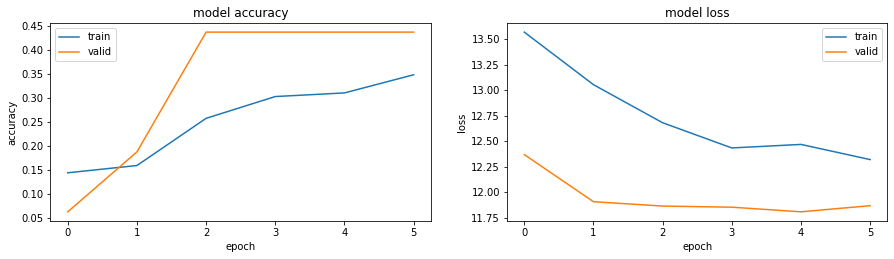


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 159ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.06250

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.06250

Epoch 4: val_accuracy did not improve from 0.06250
Epoch 4: early stopping
1/1 [==============================] - 0s 46ms/step - loss: 105.2169 - accuracy: 0.0625

LOSS:	105.21686553955078 	 ACCURACY:	0.0625
[105.21686553955078, 0.0625]



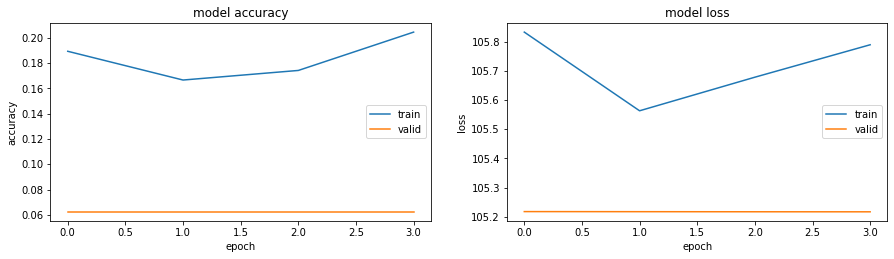


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.18750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.18750

Epoch 4: val_accuracy did not improve from 0.18750
Epoch 4: early stopping
1/1 [==============================] - 0s 38ms/step - loss: 2.6422 - accuracy: 0.1875

LOSS:	2.6422219276428223 	 ACCURACY:	0.1875
[2.6422219276428223, 0.1875]



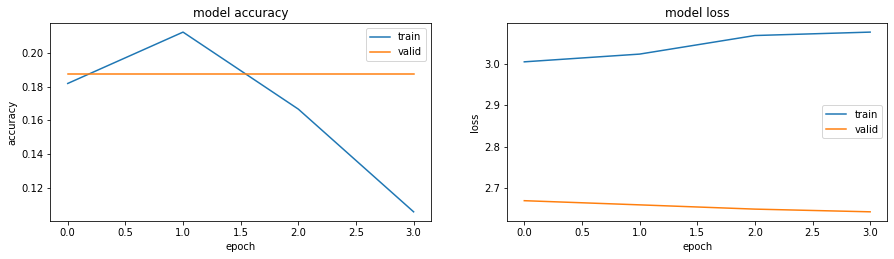


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 173ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.25000 to 0.43750, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.43750

Epoch 5: val_accuracy improved from 0.43750 to 0.50000, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.50000

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.50000

Epoch 8: val_accuracy did not improve from 0.50000
Epoch 8: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 3.9683 - accuracy: 0.3750

LOSS:	3.968250274658203 	 ACCURACY:	0.375
[3.968250274658203, 0.375]


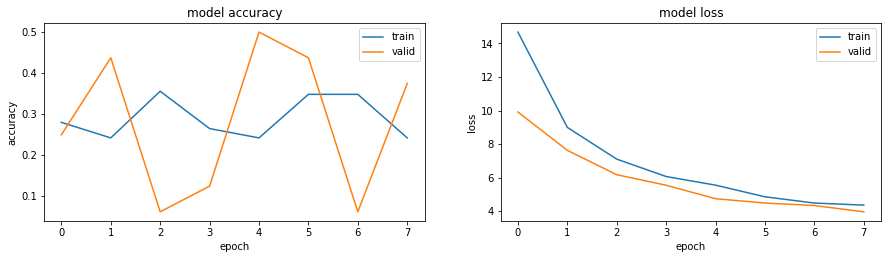


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
1/1 [==============================] - 0s 170ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy improved from 0.43750 to 0.50000, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.50000

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 6: val_accuracy did not improve from 0.50000

Epoch 7: val_accuracy did not improve from 0.50000
Epoch 7: early stopping
1/1 [==============================] - 0s 29ms/step - loss: 10.6650 - accuracy: 0.4375

LOSS:	10.665017127990723 	 ACCURACY:	0.4375
[10.665017127990723, 0.4375]



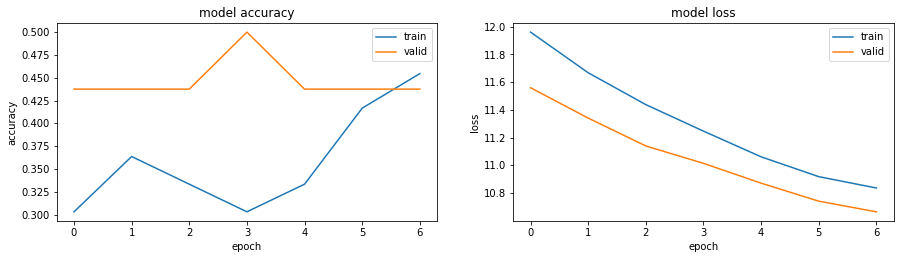


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 183ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.18750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.18750

Epoch 4: val_accuracy did not improve from 0.18750
Epoch 4: early stopping
1/1 [==============================] - 0s 36ms/step - loss: 105.4113 - accuracy: 0.1875

LOSS:	105.41128540039062 	 ACCURACY:	0.1875
[105.41128540039062, 0.1875]



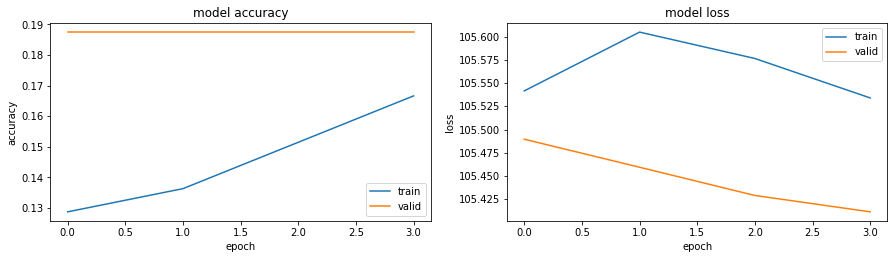


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 172ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 27ms/step - loss: 101.5515 - accuracy: 0.4375

LOSS:	101.55152130126953 	 ACCURACY:	0.4375
[101.55152130126953, 0.4375]



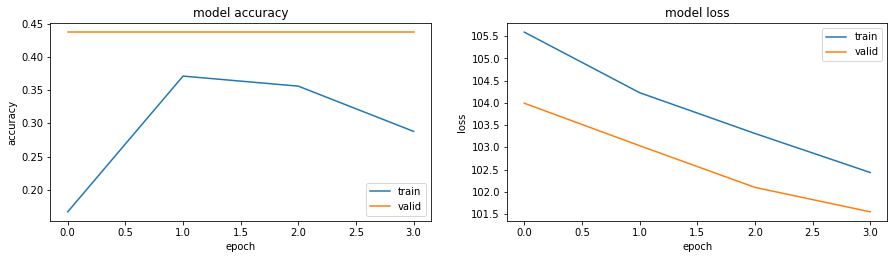


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 190ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 2.5428 - accuracy: 0.4375

LOSS:	2.5428085327148438 	 ACCURACY:	0.4375
[2.5428085327148438, 0.4375]



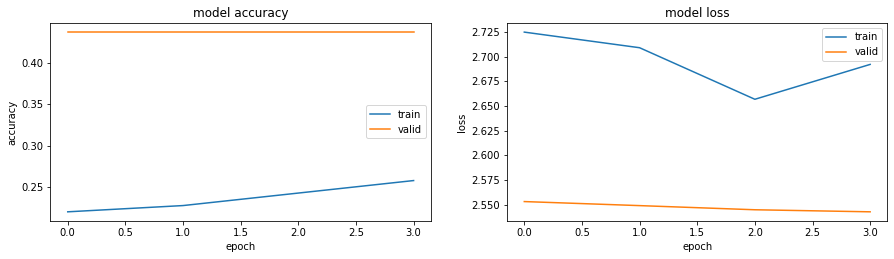


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 182ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 42ms/step - loss: 2.4707 - accuracy: 0.4375

LOSS:	2.4707305431365967 	 ACCURACY:	0.4375
[2.4707305431365967, 0.4375]



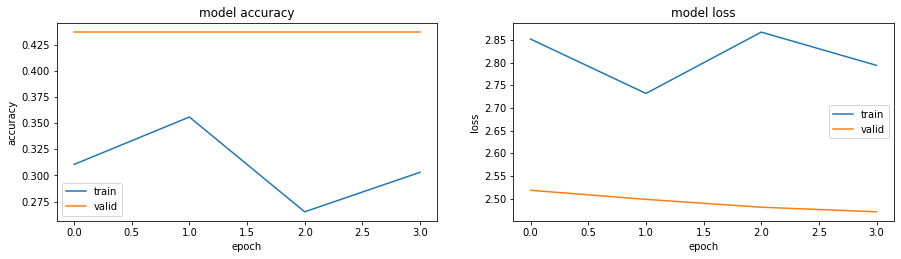


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 7.00e-01 3.20e+01 3.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 23ms/step - loss: 92.6493 - accuracy: 0.4375

LOSS:	92.64926147460938 	 ACCURACY:	0.4375
[92.64926147460938, 0.4375]



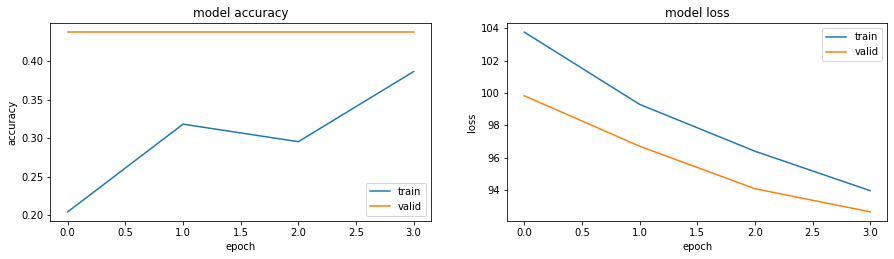


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 169ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 42ms/step - loss: 105.0897 - accuracy: 0.4375

LOSS:	105.0897445678711 	 ACCURACY:	0.4375
[105.0897445678711, 0.4375]



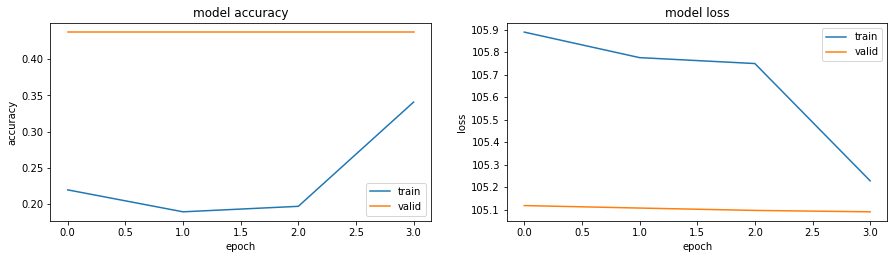


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.12500

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.12500

Epoch 4: val_accuracy did not improve from 0.12500
Epoch 4: early stopping
1/1 [==============================] - 0s 30ms/step - loss: 104.5124 - accuracy: 0.1250

LOSS:	104.51238250732422 	 ACCURACY:	0.125
[104.51238250732422, 0.125]



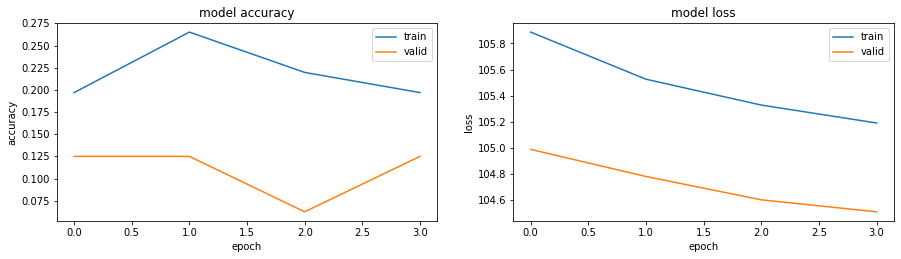


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 10.0118 - accuracy: 0.4375

LOSS:	10.011784553527832 	 ACCURACY:	0.4375
[10.011784553527832, 0.4375]



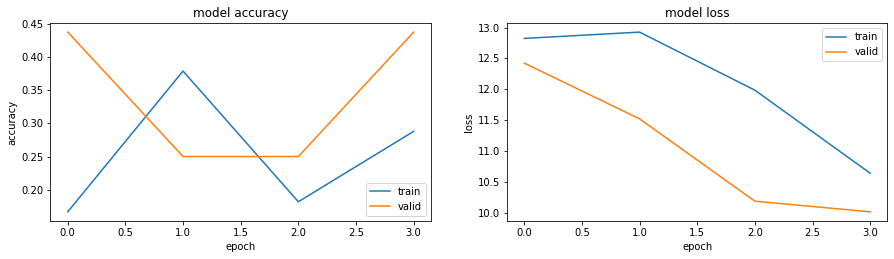


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
1/1 [==============================] - 0s 166ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 32ms/step - loss: 75.6229 - accuracy: 0.4375

LOSS:	75.62287139892578 	 ACCURACY:	0.4375
[75.62287139892578, 0.4375]



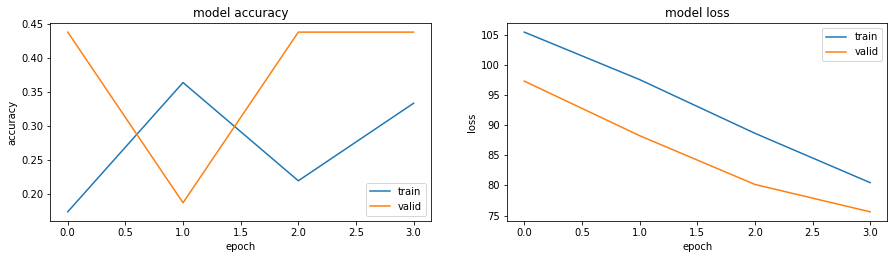


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 175ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 25ms/step - loss: 103.8677 - accuracy: 0.4375

LOSS:	103.86774444580078 	 ACCURACY:	0.4375
[103.86774444580078, 0.4375]



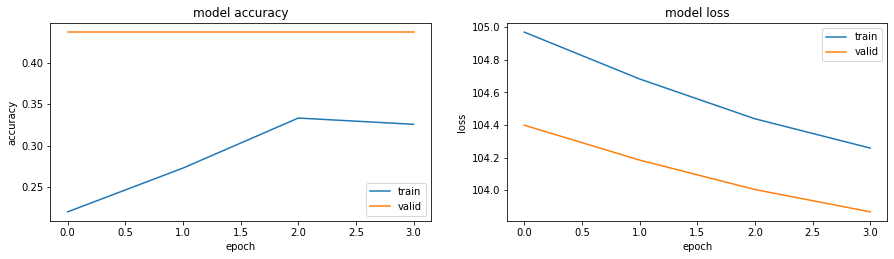


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]
1/1 [==============================] - 0s 171ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.25000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.25000

Epoch 4: val_accuracy did not improve from 0.25000
Epoch 4: early stopping
1/1 [==============================] - 0s 24ms/step - loss: 12.0418 - accuracy: 0.2500

LOSS:	12.041801452636719 	 ACCURACY:	0.25
[12.041801452636719, 0.25]



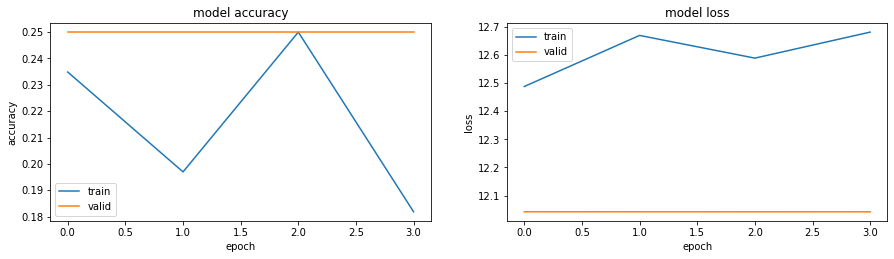


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
1/1 [==============================] - 0s 189ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 40ms/step - loss: 2.5450 - accuracy: 0.4375

LOSS:	2.5450243949890137 	 ACCURACY:	0.4375
[2.5450243949890137, 0.4375]



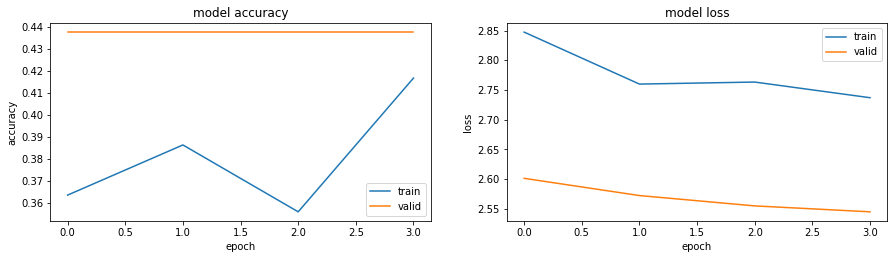


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 167ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.18750

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.18750

Epoch 4: val_accuracy did not improve from 0.18750
Epoch 4: early stopping
1/1 [==============================] - 0s 35ms/step - loss: 105.0467 - accuracy: 0.1875

LOSS:	105.04672241210938 	 ACCURACY:	0.1875
[105.04672241210938, 0.1875]



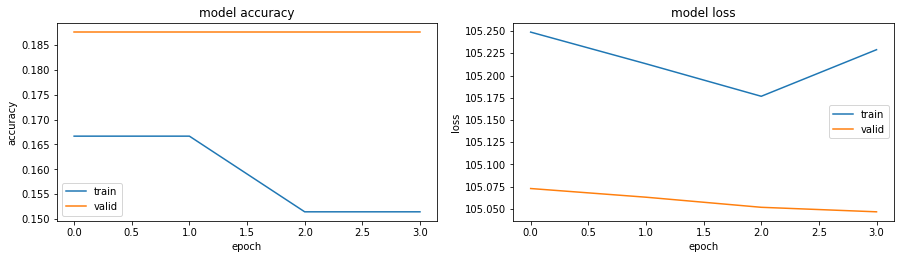


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
1/1 [==============================] - 0s 177ms/step - loss: 1.6098 - accuracy: 0.5000

Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.43750

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.43750

Epoch 4: val_accuracy did not improve from 0.43750
Epoch 4: early stopping
1/1 [==============================] - 0s 31ms/step - loss: 104.1706 - accuracy: 0.4375

LOSS:	104.17059326171875 	 ACCURACY:	0.4375
[104.17059326171875, 0.4375]



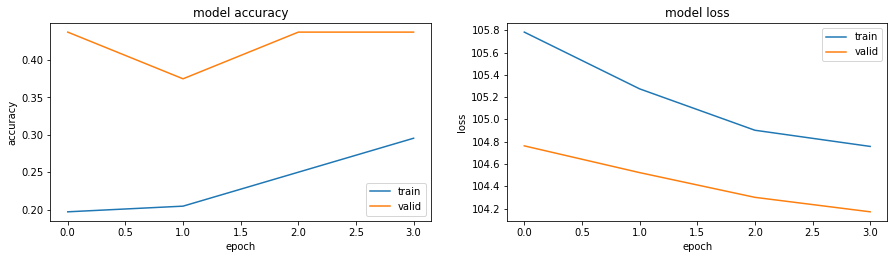

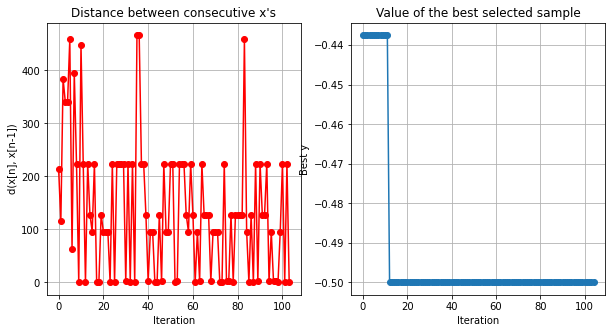

In [77]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('DR_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],
  evaluation[1]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'DR_best.h5', overwrite=False,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [78]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	64.0
	learning_rate:	0.0001
	l2:	0.1
	activation:	relu
	rate:	0.5
	batch:	32.0
 optim SGD
optimized accuracy: [0.5]


In [79]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('DR_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense_2 (Dense)             (None, 64)                122944    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 123,269
Trainable params: 123,269
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 151ms/step - loss: 1.6098 - accuracy: 0.5000
Restored model, accuracy: 50.00%


In [80]:
best_model.evaluate(features_valid, y_test)

1/1 [==============================] - 0s 28ms/step - loss: 1.6098 - accuracy: 0.5000


[1.6097722053527832, 0.5]

In [81]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Sat May 28 12:25:49 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           254.90895986557007 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o

Test model with test data

In [82]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [84]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for validation set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [85]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

2/2 [==============================] - 0s 7ms/step - loss: 1.6941 - accuracy: 0.3556
Restored model, accuracy: 35.56%


In [86]:
best_model.evaluate(features_test, y_test)

2/2 [==============================] - 0s 21ms/step - loss: 1.6941 - accuracy: 0.3556


[1.6941258907318115, 0.35555556416511536]